In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import pandas as pd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

In [7]:
df = pd.read_csv('accidental-deaths-in-usa-monthly.csv', index_col=['Month'], parse_dates=['Month'])

In [8]:
df.head()

,"Accidental deaths in USA: monthly, 1973 - 1978"
Month,
1973-01-01,9007
1973-02-01,8106
1973-03-01,8928
1973-04-01,9137
1973-05-01,10017


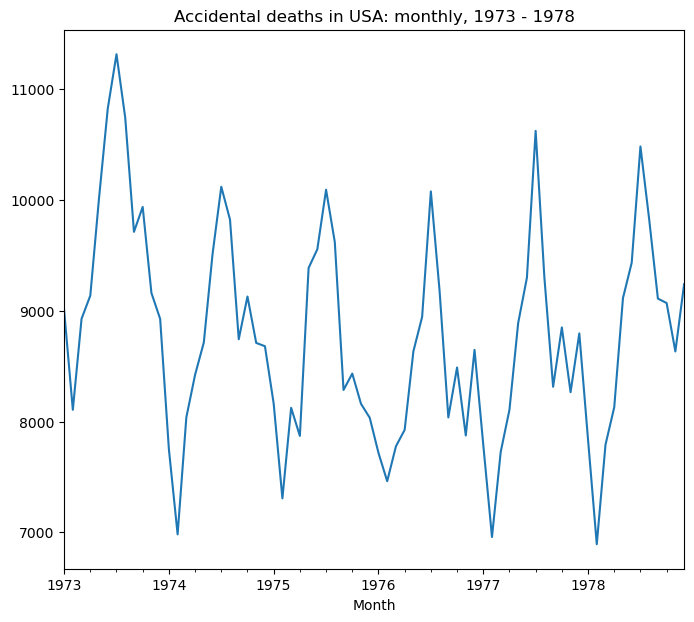

In [9]:
df['Accidental deaths in USA: monthly, 1973 - 1978'].plot(figsize=(8,7), title = "Accidental deaths in USA: monthly, 1973 - 1978")
plt.show()

Критерий Дики-Фуллера: p=0.102481


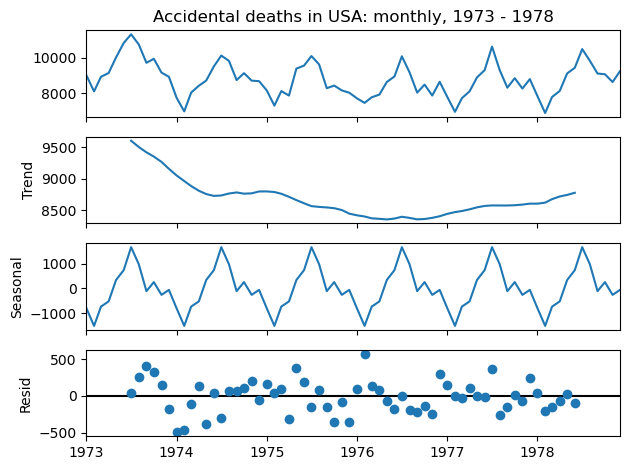

In [10]:
sm.tsa.seasonal_decompose(df['Accidental deaths in USA: monthly, 1973 - 1978']).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['Accidental deaths in USA: monthly, 1973 - 1978'])[1])

In [11]:
def check_stationarity(series):
    result = sm.tsa.stattools.adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1]<0.05:
        print('Time Series is stationary')
    else: 
        print('Time Series is not stationary')

In [12]:
check_stationarity(df['Accidental deaths in USA: monthly, 1973 - 1978'])

ADF Statistic: -2.555798
p-value: 0.102481
Time Series is not stationary


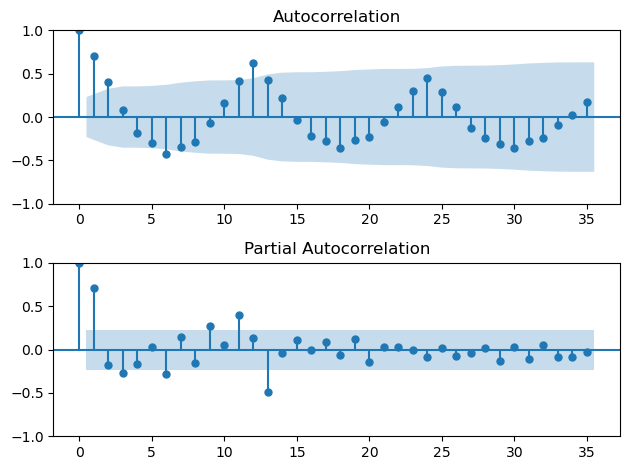

In [13]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(df['Accidental deaths in USA: monthly, 1973 - 1978'], lags=35, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(df['Accidental deaths in USA: monthly, 1973 - 1978'], lags=35, ax=ax[1])
plt.tight_layout()
plt.show()

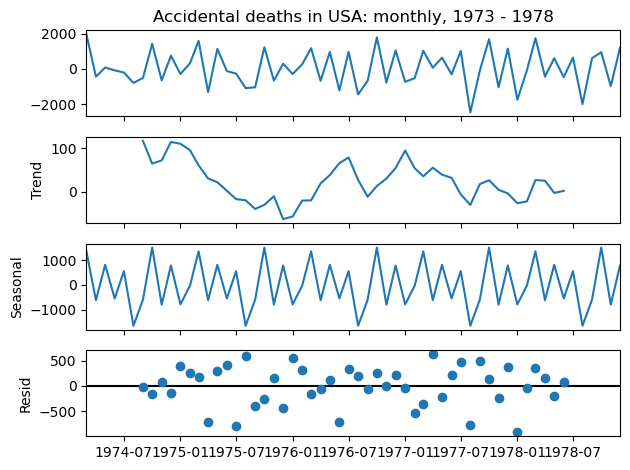

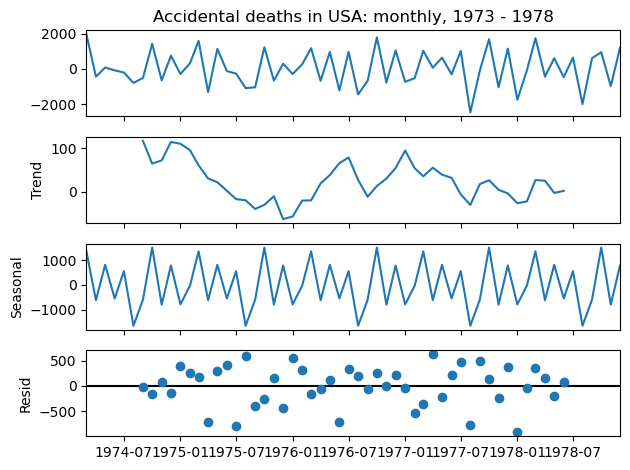

In [14]:
sm.tsa.seasonal_decompose(df['Accidental deaths in USA: monthly, 1973 - 1978'].diff(13).diff(1).dropna()).plot()

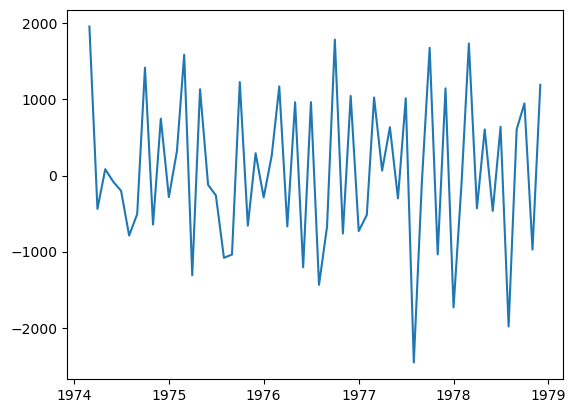

In [15]:
plt.plot(df.diff(13).diff(1))
plt.show()

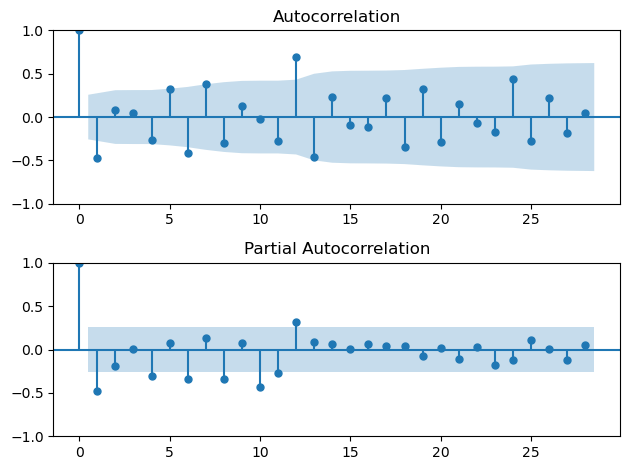

In [16]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(df['Accidental deaths in USA: monthly, 1973 - 1978'].diff(13).diff(1).dropna(), lags=28, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(df['Accidental deaths in USA: monthly, 1973 - 1978'].diff(13).diff(1).dropna(), lags=28, ax=ax[1])
plt.tight_layout()
plt.show()

In [17]:
check_stationarity(df['Accidental deaths in USA: monthly, 1973 - 1978'].diff(13).diff(1).dropna())

ADF Statistic: -2.935014
p-value: 0.041425
Time Series is stationary


In [18]:
ps = range(0, 5)
d=1
qs = range(0, 4)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

In [19]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df['Accidental deaths in USA: monthly, 1973 - 1978'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[3], D, param[3], 24)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
52  (2, 2, 2, 0)  701.118466
54  (2, 2, 4, 0)  701.118466
50  (2, 2, 0, 0)  701.118466
51  (2, 2, 1, 0)  701.118466
53  (2, 2, 3, 0)  701.118466
CPU times: total: 17.8 s
Wall time: 16.5 s


                                             SARIMAX Results                                              
Dep. Variable:     Accidental deaths in USA: monthly, 1973 - 1978   No. Observations:                   72
Model:                            SARIMAX(2, 1, 2)x(0, 1, [], 24)   Log Likelihood                -345.559
Date:                                            Wed, 28 Feb 2024   AIC                            701.118
Time:                                                    19:48:16   BIC                            710.369
Sample:                                                01-01-1973   HQIC                           704.600
                                                     - 12-01-1978                                         
Covariance Type:                                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

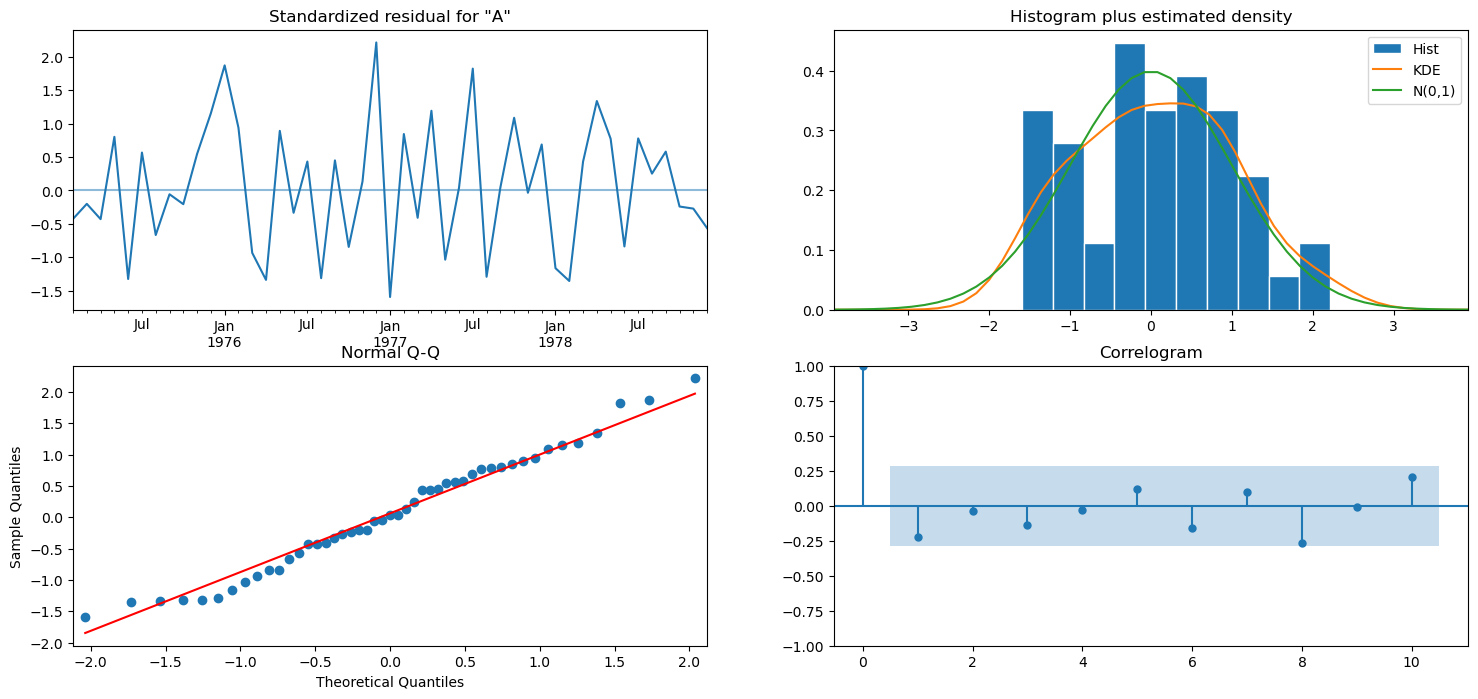

In [20]:
print(best_model.summary())
best_model.plot_diagnostics(figsize=(18, 8))
plt.show()

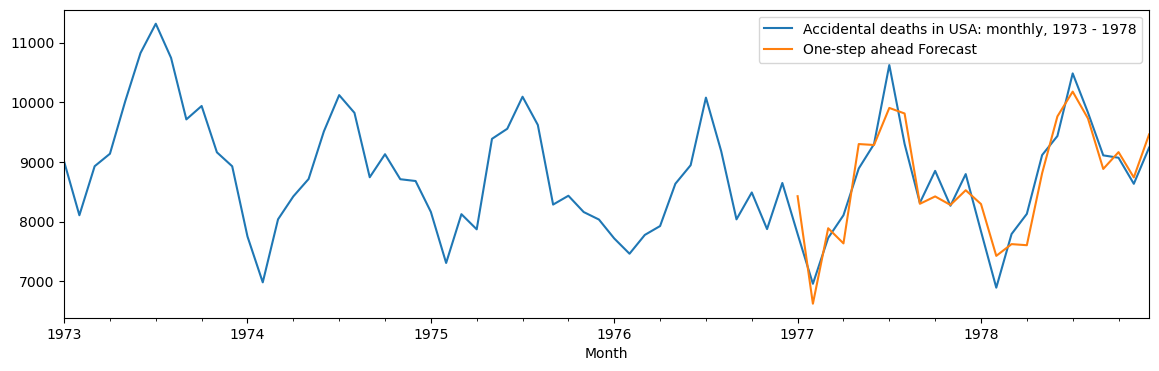

In [21]:
pred = best_model.get_prediction(start=pd.to_datetime('1977'), dynamic=False)
pred_ci = pred.conf_int()
ax = df.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', figsize=(14, 4))
plt.legend()
plt.show()

In [22]:
forecast = best_model.get_forecast(steps=24)

In [24]:
forecast_mean = forecast.predicted_mean


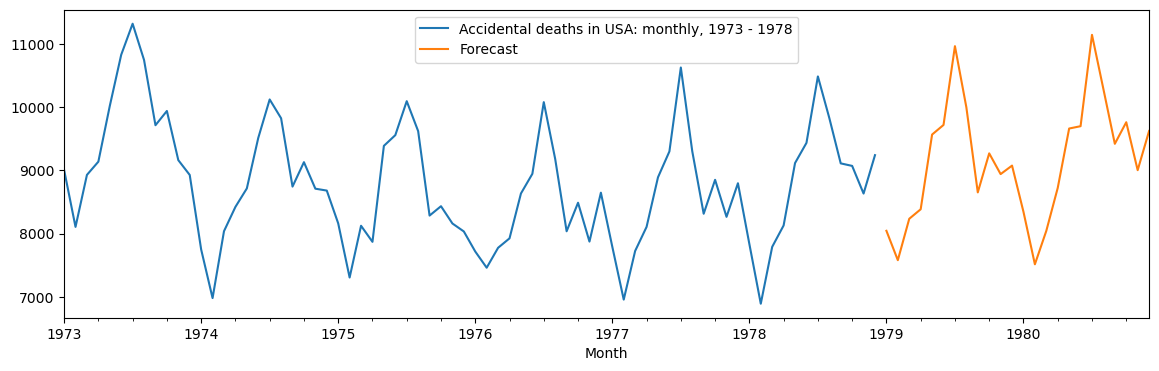

In [26]:
ax = df.plot(label='observed')
forecast_mean.plot(ax=ax, label='Forecast', figsize=(14, 4))
plt.legend()
plt.show()

График предстказывает рост числа смертей